# Personal Information
Name: **Rick Sunder**

StudentID: **12216321**

Email: [**rick.sunder@student.uva.nl**](rick.sunder@student.uva.nl)

Submitted on: **19.03.2023**

# Data Context
**To predict and explain air pollution patterns using citizen-contributed odor reports and environmental sensing data, two types of data are collected: citizen-contributed odor reports and environmental sensing data.**

**Citizen-contributed odor reports were obtained through a mobile application that allows users to report odors associated with air pollution in real-time. The application prompts users to indicate whether they smell something unpleasant or unusual, and if so, to describe the odor and rate its intensity on a scale of one to five. The intensity of the smell was described with one being 'Just Fine!' to five being 'About as bad as it gets'. This data was first stored in a database and then uploaded to the Smell Pittsburgh GitHub repository where it could be extracted and used for this research. The application collected the date, time, latitude, longitude, zipcode, severity of the smell, smell description, felt symptoms and additional comments of each report.** 

**Environmental sensing data was obtained from a network of air quality monitors located throughout area of Pittsburgh. The monitors measured various air quality parameters such as particulate matter, ozone, and nitrogen dioxide, and transmitted this data to a central database every hour. The data of that database was then extracted and uploaded to the Smell Pittsburgh GitHub repository.**

# Data Description

Exploratorty data analysis will be done in more detail... For each plot a description is given. 



In [34]:
import os
import pandas as pd
import numpy as np
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import isfile, join
from os import listdir
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from pandas.api.indexers import FixedForwardWindowIndexer
from sklearn.decomposition import PCA
import plotly.express as px
import contextily as ctx
import geopandas as gpd

# Data Loading

In [11]:
path = "C:/Users/Rick/OneDrive/Information studies/Year 2/Master thesis 1/data/esdr_raw"
list_of_files = [f for f in listdir(path) if isfile(join(path, f))]
sensor_raw_list = []
for f in list_of_files:
    sensor_raw_list.append(pd.read_csv(join(path, f)).set_index("EpochTime"))
    
display(sensor_raw_list[0].head())


,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH
EpochTime,,,,,
1477891800,0.0,0.0,51.7,343.0,3.6
1477895400,0.0,0.0,52.7,351.0,3.5
1477899000,0.0,0.0,52.6,359.0,3.4
1477902600,0.0,0.0,48.3,5.0,2.1
1477906200,0.0,0.0,31.1,41.0,2.2


# Data preprocessing

In [15]:
def answer_preprocess_sensor(df_list):
    """
    This function is the answer of task 5.
    Preprocess sensor data.
    
    Parameters
    ----------
    df_list : list of pandas.DataFrame
        A list of data frames that contain sensor data from multiple stations.
         
    Returns
    -------
    pandas.DataFrame
        The preprocessed sensor data.
    """
    # Resample all the data frames.
    df_resample_list = []
    for df in df_list:
        # Convert the timestamp to datetime.
        df.index = pd.to_datetime(df.index, unit="s", utc=True)
        # Resample the timestamps by hour and average all the previous values.
        # Because we want data from the past, so label need to be "right".
        df_resample_list.append(df.resample("60Min", label="right").mean())
    
    # Merge all data frames.
    df = df_resample_list.pop(0)
    index_name = df.index.name
    while len(df_resample_list) != 0:
        # We need to use outer merging since we want to preserve data from both data frames.
        df = pd.merge_ordered(df, df_resample_list.pop(0), on=df.index.name, how="outer", fill_method=None)
        # Move the datetime column to index
        df = df.set_index(index_name)

    # Fill in the missing data with value -1.
    df = df.fillna(-1)
    return df

df_sensor = answer_preprocess_sensor(sensor_raw_list)
display(df_sensor.head())


def answer_preprocess_smell(df):
    """
    This function is the answer of task 4.
    Preprocess smell data.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The raw smell reports data.
         
    Returns
    -------
    pandas.DataFrame
        The preprocessed smell data.
    """
    # Copy the dataframe to avoid editing the original one.
    df = df.copy(deep=True)
    
    # Drop the columns that we do not need.
    df = df.drop(columns=["feelings_symptoms", "smell_description", "zipcode"])
    
    # Select only the reports within the range of 3 and 5.
    df = df[(df["smell_value"]>=3)&(df["smell_value"]<=5)]
    
    # Convert the timestamp to datetime.
    df.index = pd.to_datetime(df.index, unit="s", utc=True)

    # Resample the timestamps by hour and sum up all the future values.
    # Because we want data from the future, so label need to be "left".
    df = df.resample("60Min", label="left").sum()
    
    # Fill in the missing data with value 0.
    df = df.fillna(0)
    return df

smell_raw = pd.read_csv("C:/Users/Rick/OneDrive/Information studies/Year 2/Master thesis 1/data/smell_raw.csv").set_index("EpochTime")
display(smell_raw.head())
df_smell = answer_preprocess_smell(smell_raw)
display(df_smell.head())

,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH,3.feed_1.PM25B_UG_M3..3.feed_1.PM25T_UG_M3..3.feed_1.PM25_640_UG_M3,3.feed_23.CO_PPM..3.feed_23.CO_PPB,3.feed_23.PM10_UG_M3,3.feed_24.PM10_UG_M3,3.feed_26.PM10B_UG_M3..3.feed_59665.PM10_640_UG_M3,...,3.feed_3.PM10B_UG_M3..3.feed_3.PM10_640_UG_M3,3.feed_11067.CO_PPB..3.feed_43.CO_PPB,3.feed_11067.NO2_PPB..3.feed_43.NO2_PPB,3.feed_11067.NOX_PPB..3.feed_43.NOX_PPB,3.feed_11067.NO_PPB..3.feed_43.NO_PPB,3.feed_11067.PM25T_UG_M3..3.feed_43.PM25T_UG_M3,3.feed_11067.SIGTHETA_DEG..3.feed_43.SIGTHETA_DEG,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG,3.feed_11067.SONICWS_MPH..3.feed_43.SONICWS_MPH,3.feed_5975.PM2_5
EpochTime,,,,,,,,,,,,,,,,,,,,,
2016-10-31 06:00:00+00:00,0.0,0.0,51.7,343.0,3.6,6.0,0.2,7.0,7.0,13.0,...,9.0,159.5,2.5,3.5,0.9,-1.0,46.8,17.0,2.1,0.0
2016-10-31 07:00:00+00:00,0.0,0.0,52.7,351.0,3.5,4.0,0.2,8.0,8.0,7.0,...,13.0,-1.0,2.7,3.8,1.1,5.0,46.1,10.0,2.2,5.0
2016-10-31 08:00:00+00:00,0.0,0.0,52.6,359.0,3.4,3.0,0.2,5.0,7.0,2.0,...,7.0,133.0,-1.0,-1.0,-1.0,9.0,22.4,43.0,4.6,9.0
2016-10-31 09:00:00+00:00,0.0,0.0,48.3,5.0,2.1,2.0,0.2,3.0,2.0,4.0,...,11.0,236.6,7.3,14.6,7.2,3.0,41.8,21.0,1.7,3.0
2016-10-31 10:00:00+00:00,0.0,0.0,31.1,41.0,2.2,3.0,0.2,5.0,5.0,5.0,...,10.0,269.3,8.2,13.1,4.8,9.0,42.0,50.0,1.4,9.0


,skewed_latitude,skewed_longitude,smell_value,smell_description,feelings_symptoms,additional_comments,zipcode
EpochTime,,,,,,,
1477935134,40.4293,-79.8720,1,NaN,NaN,NaN,15221
1477935767,40.3624,-79.9749,1,NaN,NaN,NaN,15227
1477955141,40.3275,-79.9606,1,NaN,NaN,NaN,15236
1477956180,40.4252,-79.8956,2,Woodsmoke,NaN,NaN,15218
1477956293,40.4237,-79.8964,3,Wood smoke,NaN,NaN,15218


,skewed_latitude,skewed_longitude,smell_value
EpochTime,,,
2016-10-31 23:00:00+00:00,40.4237,-79.8964,3
2016-11-01 00:00:00+00:00,0.0000,0.0000,0
2016-11-01 01:00:00+00:00,0.0000,0.0000,0
2016-11-01 02:00:00+00:00,0.0000,0.0000,0
2016-11-01 03:00:00+00:00,40.3627,-79.9729,3


# Data analysis

### Analysis 1: Look at the frequency of smell values (per hour)
Make sure to add some explanation of what you are doing in your code. This will help you and whoever will read this a lot in following your steps.

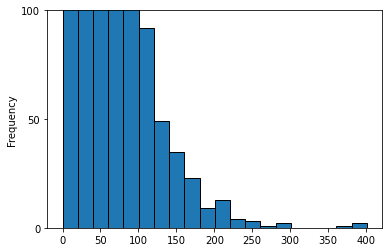

In [17]:
fig = df_smell["smell_value"].plot(kind="hist", bins=20, ylim=(0,100), edgecolor="black").set_yticks([0,50,100])

### Analysis 2: Mean report value per day per hour

Here you can see that all reports are mostly done in the morning more at the end or beginning of the week. 

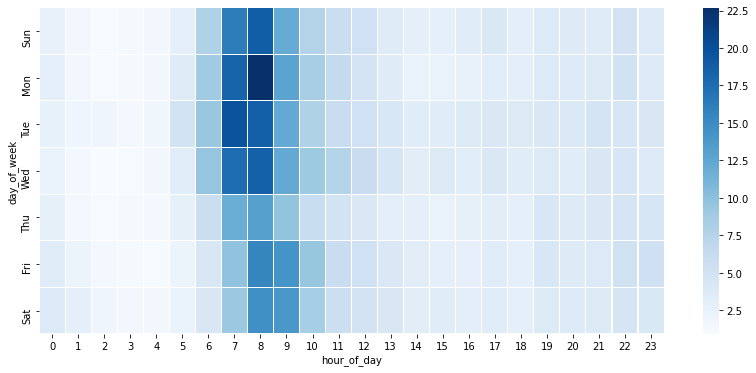

In [18]:
def is_datetime_obj_tz_aware(dt):
    """
    Find if the datetime object is timezone aware.
    
    Parameters
    ----------
    dt : pandas.DatetimeIndex
        A datatime index object.
    """
    return dt.tzinfo is not None and dt.tzinfo.utcoffset(dt) is not None


def plot_smell_by_day_and_hour(df):
    """
    Plot the average number of smell reports by the day of week and the hour of day.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed smell data.
    """
    # Copy the data frame to prevent editing the original one.
    df = df.copy(deep=True)
    
    # Convert timestamps to the local time in Pittsburgh.
    if is_datetime_obj_tz_aware(df.index):
        df.index = df.index.tz_convert(pytz.timezone("US/Eastern"))
    else:
        df.index = df.index.tz_localize(pytz.utc, ambiguous="infer").tz_convert(pytz.timezone("US/Eastern"))
    
    # Compute the day of week and the hour of day.
    df["day_of_week"] = df.index.dayofweek
    df["hour_of_day"] = df.index.hour
    
    # Plot the graph.
    y_l = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    df_pivot = pd.pivot_table(df, values="smell_value", index=["day_of_week"], columns=["hour_of_day"], aggfunc=np.mean)
    f, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(df_pivot, annot=False, cmap="Blues", fmt="g", linewidths=0.1, yticklabels=y_l, ax=ax)
    
    
plot_smell_by_day_and_hour(df_smell)

### Analysis 3: Show location of all smell reports on the pittsburgh map

This plot shows how the data can be clustered in different regions of pittsburgh. It is also the possibility to split it into 9 equal parts or 3 equal parts...

          latitude  longitude
cluster                      
0        40.444331 -79.923822
1        40.342378 -79.954670
2        40.358191 -80.046663
3        40.421988 -79.878474
4        40.501914 -80.073004
5        40.449358 -79.979840
6        40.476304 -79.785499
7        40.536637 -79.918902
8        40.320412 -79.877822


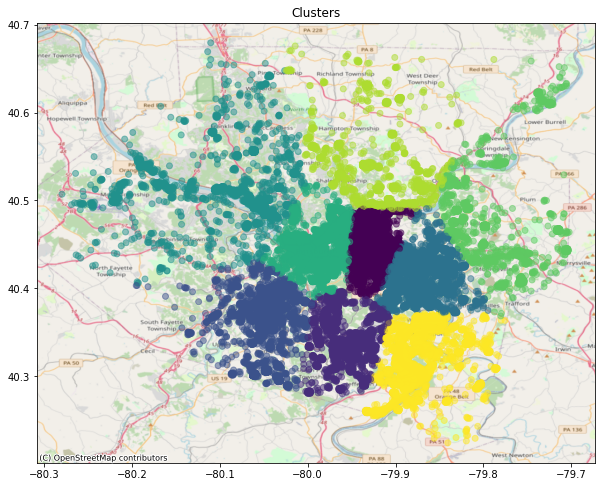

In [19]:
smell_location = smell_raw[["skewed_latitude", "skewed_longitude"]]
smell_location = smell_location.rename(columns={'skewed_latitude': 'latitude', 'skewed_longitude': 'longitude'})
#locations = pd.concat([all_sensor_locations, smell_location], axis=0, ignore_index=True)
locations = smell_location

# Create a K-Means model with 9 clusters
kmeans = KMeans(n_clusters=9)

# Fit the model to the data
kmeans.fit(locations)

# Add a new column to the dataframe with the cluster label for each data point
locations['cluster'] = kmeans.predict(locations)

# Print the mean longitude and latitude for each cluster
print(locations.groupby('cluster').mean())


# Plot the data points colored by cluster on a map background
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_title('Clusters')
ax.scatter(locations['longitude'], locations['latitude'], c=locations['cluster'], cmap='viridis', alpha=0.5)
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

### Analysis 4: See correlation between sensor station using correlation matrix

In this plot you can see that there are certain lightly colored square boxes getting created in the plot. This indicates that there are similarities for these columns, thus indicating that there is a group of correlating sensors. 

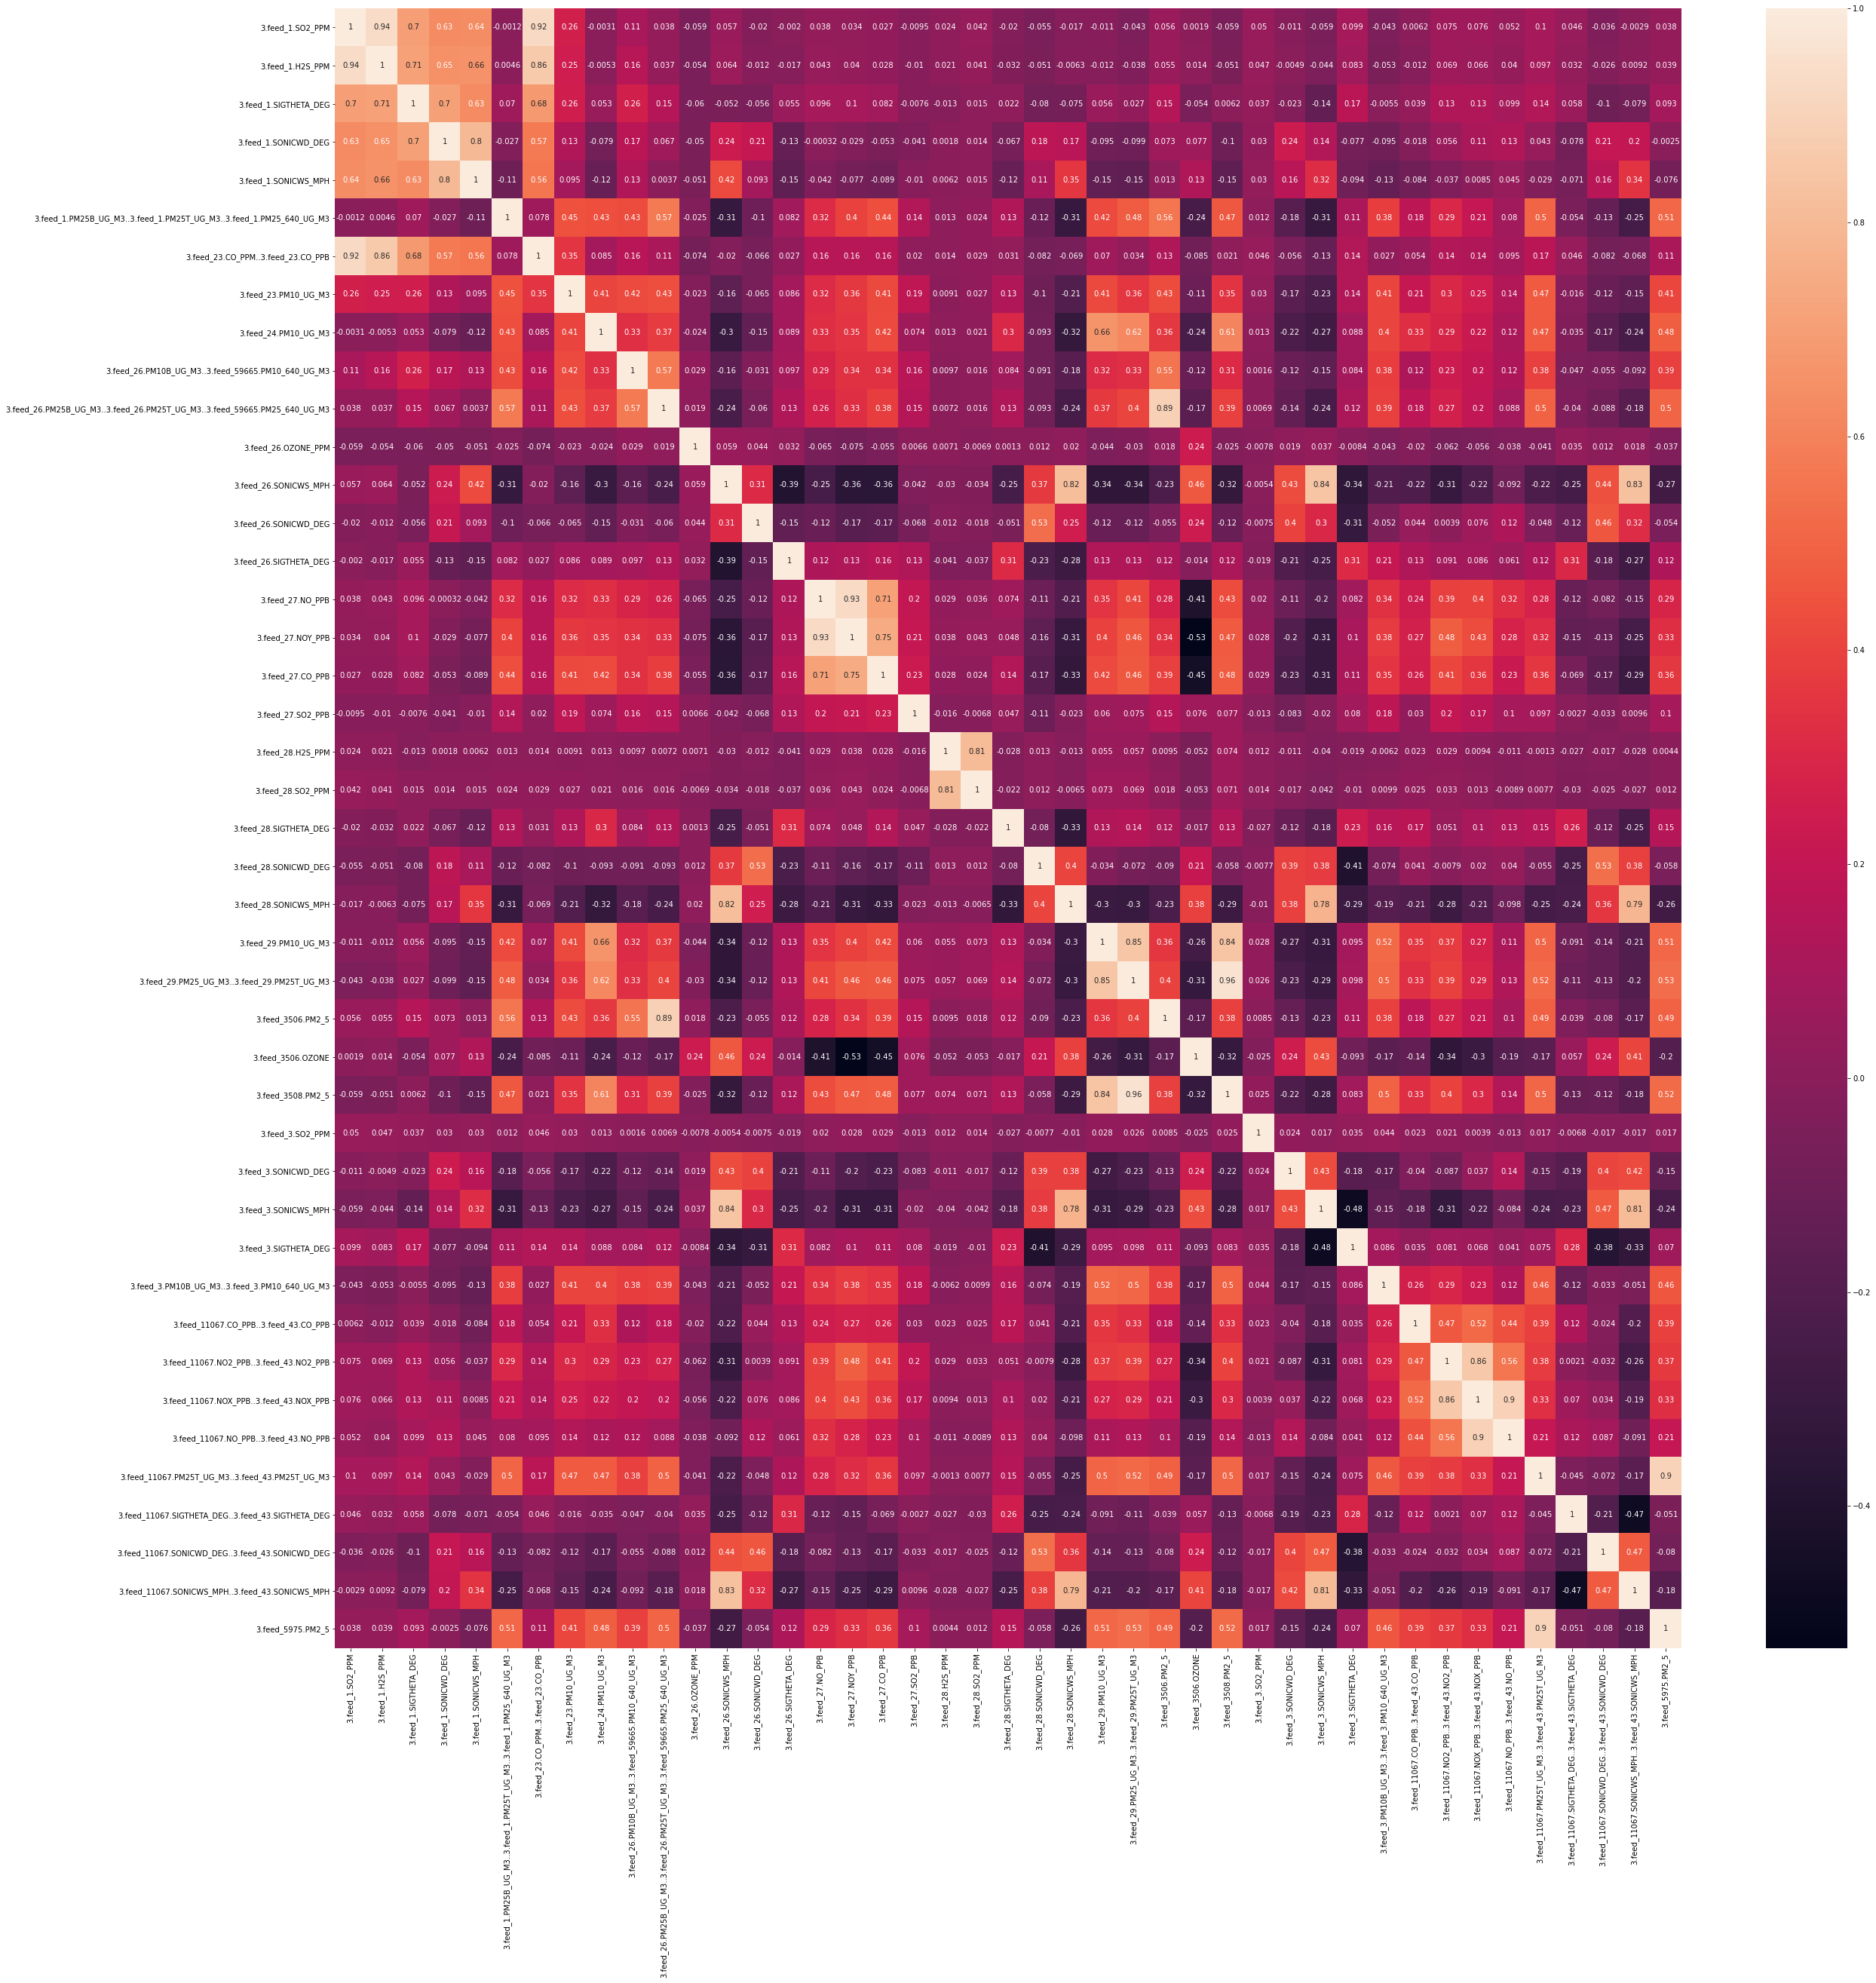

In [20]:
corr_matrix = df_sensor.corr()
plt.figure(figsize = (40,40))
sns.heatmap(corr_matrix, annot=True)
plt.show()

### 5: Check for skewness

<AxesSubplot:>

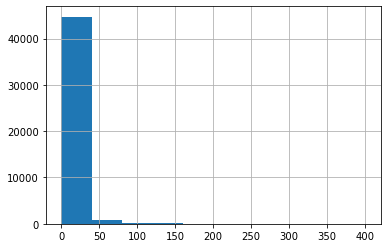

In [29]:
df_smell['smell_value'].hist()